In [254]:
#set up

#load libraries
library(gbm)
library(ggplot2)
library(GGally)
library(tidyverse)

#read in data
kcDat <- read.csv('~/Documents/kc_inspections.csv',header=TRUE)

#data cleaning
#assign some variables to be factors
cat_vars <- c('year','weekday','business_location_zip','american.traditional','mexican','american.new','italian',
             'mediterranean','indian','ethiopian','grocery','asian')
kcDat[,cat_vars] <- lapply(kcDat[,cat_vars],as.factor)


## The data

The `kcDat` data frame contains information on restaurant inspections in King County, Washington between 2015 and 2019. The inspection data has been merged with Yelp review information and some other variables have been engineered.


 - Variables
      - `inspection_serial_num`: unique inspection identifier
      - `business_record_id`: unique restaurant identifer
      - `inspection_date`: date of inspection
      - `inspection_score`: score for inspection; higher scores mean there were more violations/penalties
      - `activity_time`: length of inspection in minutes
      - `year`: year the inspection occurred
      - `weekday`: day of week inspection occurred
      - `viol_count`: number of violations that occurred in inspection
      - `prev_score_1` through `prev_score_4`: score of four most recent previous inspections, prev_score_1 being most recent
      - `business_location_zip`: zip code where restaurant is located
      - `asian`: indicator that restaurant serves Asian food


## Data Visualization and Exploration

Let's first explore and visualize the data to understand it better and if there are any relationships between variables.

In [255]:
head(kcDat)

inspection_serial_num,business_record_id,inspection_date,inspection_score,activity_time,year,weekday,viol_count,prev_score_1,prev_score_2,⋯,ethiopian,indonesian,singaporean,grocery,asian,log_inspection_score,log_prev_score_1,log_prev_score_2,log_prev_score_3,log_prev_score_4
DAPXVWYJI,PR0001011,2015-03-30,10,25,2015,Monday,1,10,20,⋯,0,0,0,0,0,2.302585,2.302585,2.995732,2.484907,2.302585
DAIQD6JTB,PR0001011,2015-06-23,15,40,2015,Tuesday,2,10,10,⋯,0,0,0,0,0,2.708050,2.302585,2.302585,2.995732,2.484907
DAN2JKZZU,PR0001011,2016-03-21,20,30,2016,Monday,3,15,10,⋯,0,0,0,0,0,2.995732,2.708050,2.302585,2.302585,2.995732
DA0UJUF5K,PR0001011,2016-08-16,15,30,2016,Tuesday,2,20,15,⋯,0,0,0,0,0,2.708050,2.995732,2.708050,2.302585,2.302585
DACPGS7VE,PR0001011,2017-03-28,5,30,2017,Tuesday,1,15,20,⋯,0,0,0,0,0,1.609438,2.708050,2.995732,2.708050,2.302585
DASZN0RMO,PR0001011,2018-10-29,5,40,2018,Monday,1,5,15,⋯,0,0,0,0,0,1.609438,1.609438,2.708050,2.995732,2.708050


We can explore relationships between the continuous variables easily through scatterplots. `ggpairs` in the `GGally` package will create a grid of scatter plots between variables as well as give us the correlation and density plots.

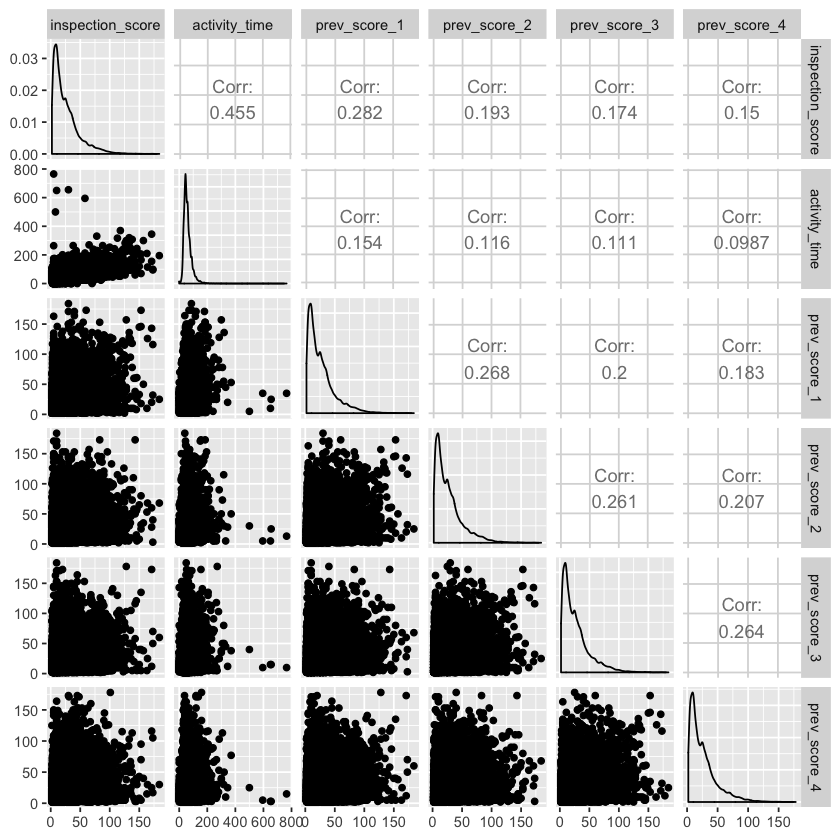

In [256]:
ggpairs(kcDat[,c('inspection_score','activity_time','prev_score_1','prev_score_2','prev_score_3',
                'prev_score_4')])

In [ ]:
#include other prompts for data exploration?

## Fit a model to predict inspection scores

We would like to fit a model that predicts the score given for an inspection of a restaurant. This model would be used to predict which restaurants are expected to have higher inspection scores so inspectors could target these restaurants.

In [257]:
#get a random subset of data to fit model
set.seed(6183)
#take 80% of data to train - leave 20% to evaluate accuracy
train <- sample(1:nrow(kcDat),floor(nrow(kcDat)*.8),replace=FALSE)
train_sub <- kcDat[train,]
test_sub <- kcDat[-train,]

We'll first build a gradient boosted tree model using previous inspection scores, the time the inspections took, and the year and weekday the inspection occured.

In [258]:
gb <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 + activity_time +
          year + weekday,
          data=train_sub,distribution = "gaussian",n.trees = 10000,shrinkage = 0.02, interaction.depth = 6)

## Assess prediction ability

Now that we've fit a model, how well does it actually predict the inspection score? We'll calculate the square root of the mean squared error (RMSE) on the 20% of data we kept as a test set. 

In [259]:
#predicting for test set from fitted model
score_pred <- predict(gb,newdata=test_sub,n.trees=8000)

#calculating RMSE
sqrt(mean((score_pred - test_sub$inspection_score)^2))

[1] 19.74558

The RMSE is about 19.8, which means that on average, our model predicts an inspection score that is 20 points off the actual score given. This is a large margin of error so our model isn't predicting very well. What might be some reasons that the model performs poorly? 

We can also graphically show how well the model is predicting by plotting the predicted values against the actual inspection scores. For a perfect model, the points would create a diagnoal line. What trends do you see in the predicted vs actual scores plot?

Warning message:
“Removed 3 rows containing missing values (geom_point).”

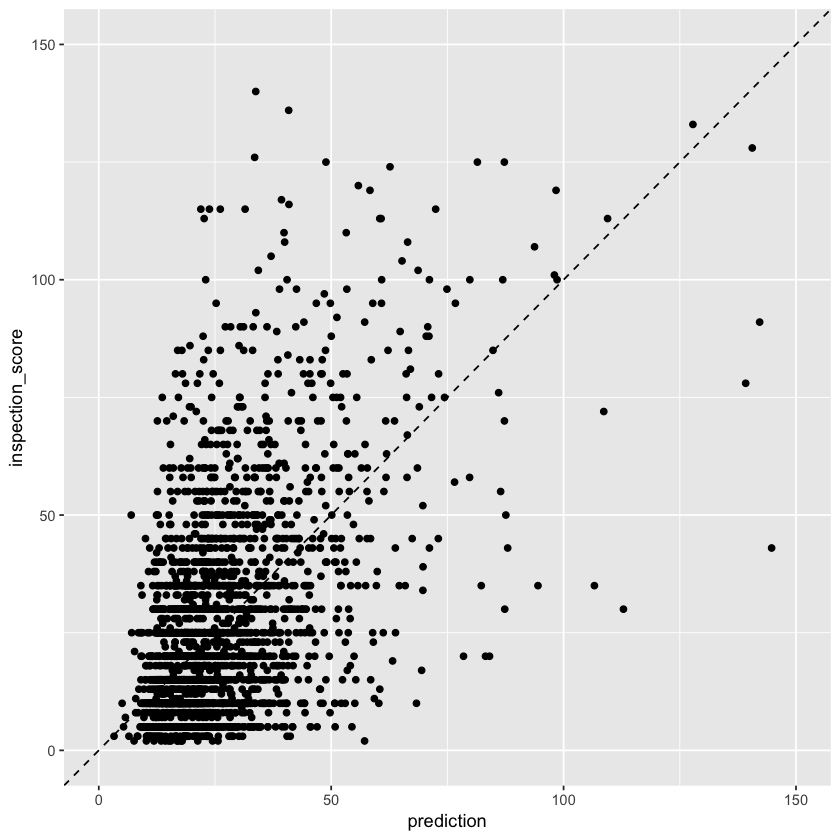

In [260]:
test_sub$prediction <- score_pred

ggplot(test_sub,aes(x=prediction,y=inspection_score)) + geom_point() + geom_abline(linetype = "dashed") +
  scale_x_continuous(limits = c(0, 150)) +
  scale_y_continuous(limits = c(0, 150))

Variable importance measures can be used to see which variables are driving the predictive ability of the model. The importance measure (rel.inf) used here is based off the number of times a variable is used for splitting the trees in the model, weighted by the squared improvement to the model after each split, averaged over all the trees in the model. Which variable seems to be driving the predictive ability of this model? Why might this variable have a lot of influence on the predicted score?

,var,rel.inf
activity_time,activity_time,34.377325
prev_score_1,prev_score_1,16.490391
prev_score_2,prev_score_2,12.048437
prev_score_3,prev_score_3,11.572868
prev_score_4,prev_score_4,11.400620
weekday,weekday,7.420423
year,year,6.689936


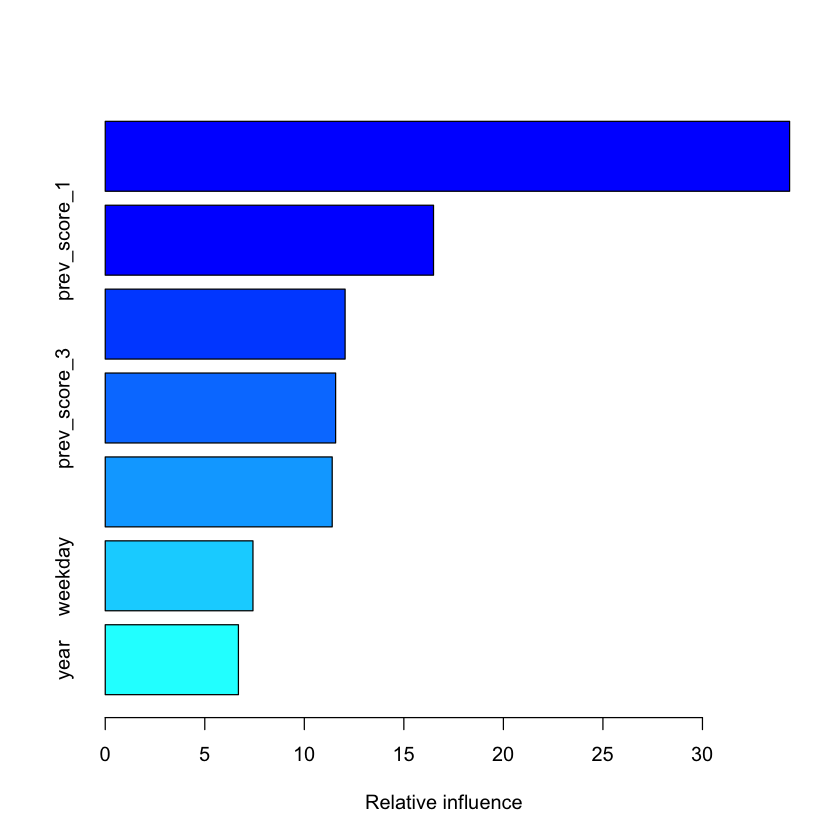

In [261]:
summary(gb)

## Adding zip code to the model

Let's add the zip code to the model to see if this improves the predictive ability.

In [266]:
#gradient boosted tree model with zip code
gb_zipcode <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 + activity_time +
          year + weekday + business_location_zip,data=train_sub
          ,distribution = "gaussian",n.trees = 10000,shrinkage = 0.02, interaction.depth = 6)

In [267]:
#predict the inspection scores and calculate RMSE
score_pred <- predict(gb_zipcode,newdata=test_sub,n.trees=8000)

sqrt(mean((score_pred-test_sub$inspection_score)^2))

[1] 19.08649

There is a small decrease in RMSE when zip code is included in the model, but because it is small, it may be due only to sampling error. We can also look at variable importance again to see if these measures have changed after including zip code.

,var,rel.inf
business_location_zip,business_location_zip,51.025176
activity_time,activity_time,20.926495
prev_score_1,prev_score_1,7.653219
prev_score_2,prev_score_2,5.007409
prev_score_4,prev_score_4,4.520511
prev_score_3,prev_score_3,4.475347
year,year,3.213067
weekday,weekday,3.178776


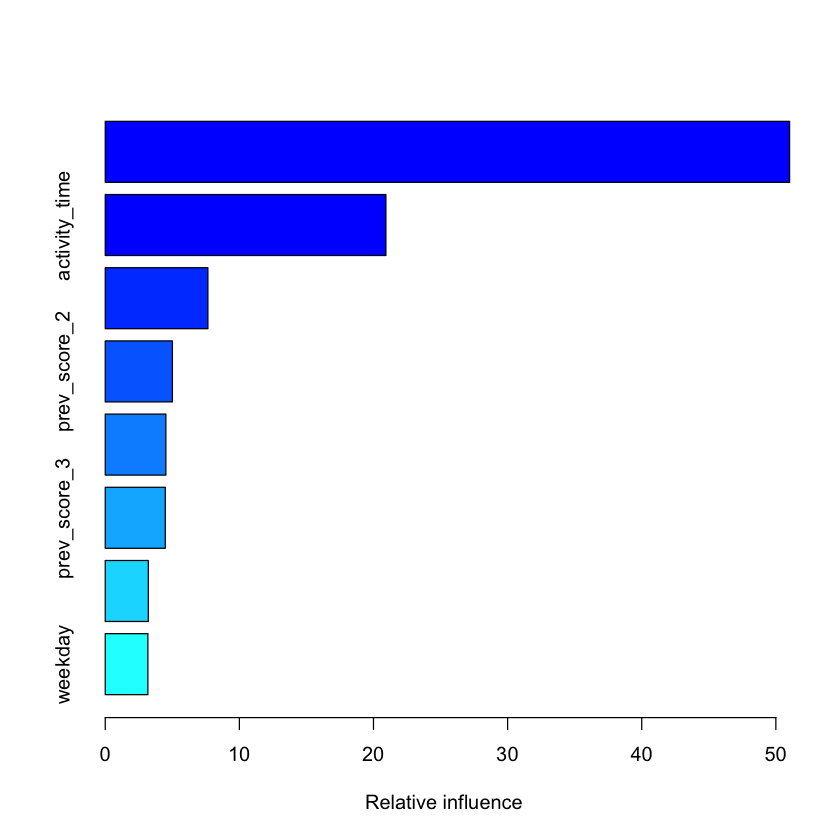

In [268]:
summary(gb_zipcode)

Zip codes seem to be the most influential variable now. However, inspectors are assigned by zip code, and some inspectors are more harsh than others when grading (see https://www.thestranger.com/seattle/mr-clean/Content?oid=568012 ). What will this mean if the allocation of resources for inspections is dictated by a model that takes zip code into account when predicting scores?

## Including cuisine category

Let's try adding the Asian restaurant indicator to see if this extra variable will improve accuracy.

In [269]:
gb_asian <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 + activity_time +
          year + weekday + asian,data=train_sub
          ,distribution = "gaussian",n.trees = 10000,shrinkage = 0.02, interaction.depth = 6)

In [270]:
#predict the inspection scores and calculate RMSE
score_pred <- predict(gb_asian,newdata=test_sub,n.trees=8000)

sqrt(mean((score_pred-test_sub$inspection_score)^2))

[1] 19.57812

,var,rel.inf
activity_time,activity_time,33.706237
prev_score_1,prev_score_1,15.710270
prev_score_2,prev_score_2,11.611234
prev_score_4,prev_score_4,10.992525
prev_score_3,prev_score_3,10.908263
weekday,weekday,7.418076
year,year,6.512462
asian,asian,3.140934


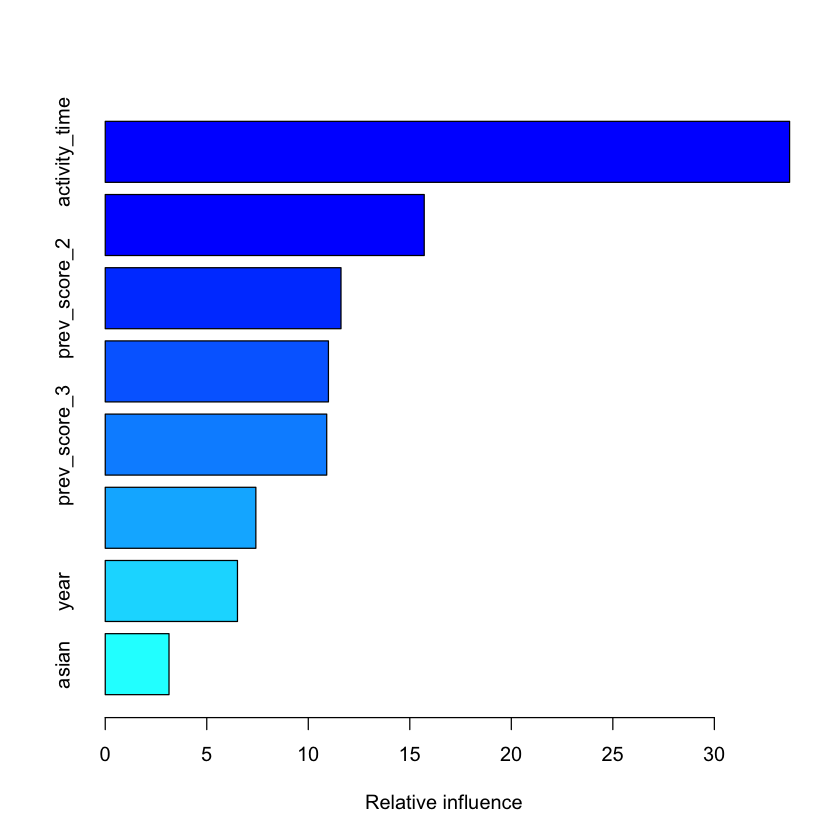

In [271]:
#look at variable importance
summary(gb_asian)

Looking at the RMSE and variable importance, including the Asian food indicator doesn't seem to improve the model either. It is the least influential variable relative to the others in the model, and the RMSE is very close to the previous two models explored. We can look futher into how the Asian food indicator is affected the prediction by plotting predicted versus actual inspections scores and splitting the two plots by whether the restaurant serves Asian food or not.

Warning message:
“Removed 3 rows containing missing values (geom_point).”

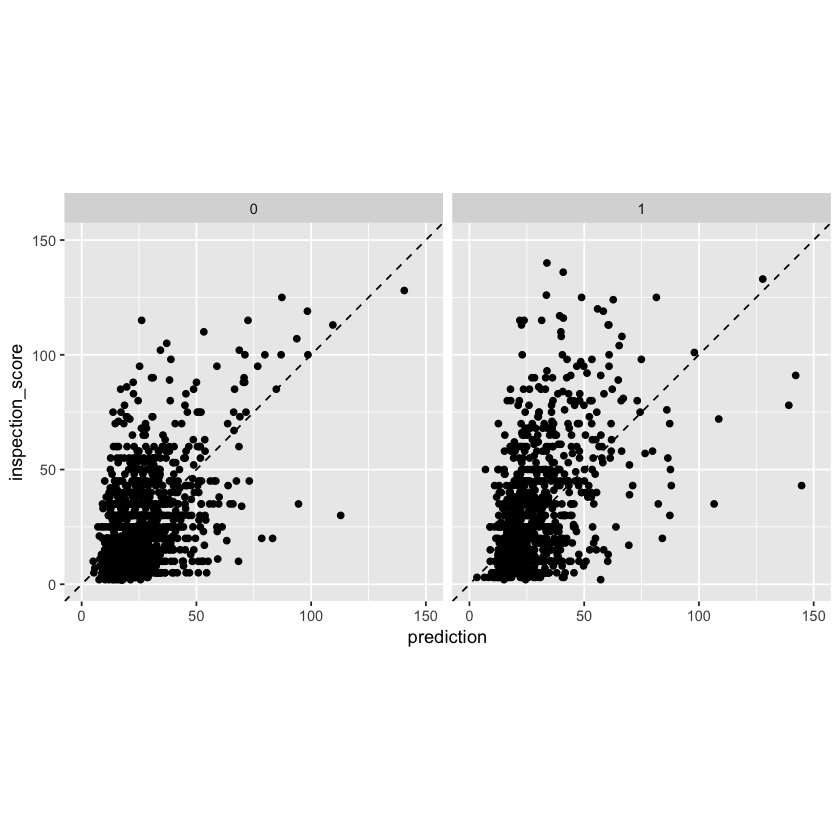

In [272]:
ggplot(test_sub,aes(x=prediction,y=inspection_score)) + geom_point() + geom_abline(linetype = "dashed") +
  facet_grid(cols = vars(asian)) + coord_fixed() +
  scale_x_continuous(limits = c(0, 150)) +
  scale_y_continuous(limits = c(0, 150))

What differences do you see between the Asian food restaurants and non-Asian restaurants?